# CONFLUENCE Tutorial: Regional Domain Modeling - Iceland

This notebook demonstrates regional domain modeling using Iceland as an example. Unlike previous tutorials that focused on single watersheds, this example:

1. **Delineates an entire region** (not just a single watershed)
2. **Includes coastal watersheds** (watersheds that drain directly to the ocean)
3. **Uses a bounding box** instead of a pour point

## Key Differences from Previous Tutorials

- **DELINEATE_BY_POURPOINT**: `False` - We're not focusing on a single outlet
- **DELINEATE_COASTAL_WATERSHEDS**: `True` - Include watersheds draining to coast
- **Regional scale**: Multiple independent watersheds

## Learning Objectives

1. Understand regional vs. watershed-scale modeling
2. Learn how to delineate coastal watersheds
3. Handle multiple independent drainage systems
4. Work with national/regional scale domains

## 1. Setup

In [1]:
# Import required libraries
import sys
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import box

# Add CONFLUENCE to path
confluence_path = Path('../').resolve()
sys.path.append(str(confluence_path))

# Import CONFLUENCE
from CONFLUENCE import CONFLUENCE

plt.style.use('default')
%matplotlib inline

print(f"Working from: {confluence_path}")

Working from: /home/darri.eythorsson/code/CONFLUENCE


## 2. Load Iceland Configuration

In [3]:
# Load the Iceland configuration
iceland_config_path = confluence_path / '0_config_files' / 'config_Iceland.yaml'

if not iceland_config_path.exists():
    raise FileNotFoundError(f"Iceland config not found at: {iceland_config_path}")

with open(iceland_config_path, 'r') as f:
    config = yaml.safe_load(f)

# Display key regional settings
print("=== Iceland Regional Configuration ===")
print(f"Domain Name: {config['DOMAIN_NAME']}")
print(f"Bounding Box: {config['BOUNDING_BOX_COORDS']}")
print(f"Delineate by Pour Point: {config['DELINEATE_BY_POURPOINT']} (Full region!)")
print(f"Include Coastal Watersheds: {config['DELINEATE_COASTAL_WATERSHEDS']}")
print(f"Stream Threshold: {config['STREAM_THRESHOLD']}")
print(f"Domain Method: {config['DOMAIN_DEFINITION_METHOD']}")

# Parse bounding box
bbox = config['BOUNDING_BOX_COORDS'].split('/')
lat_max, lon_min, lat_min, lon_max = map(float, bbox)
print(f"\nGeographic extent:")
print(f"  North: {lat_max}°N")
print(f"  South: {lat_min}°N")
print(f"  West: {lon_min}°W")
print(f"  East: {lon_max}°W")

=== Iceland Regional Configuration ===
Domain Name: Iceland
Bounding Box: 66.7267923041/-25.4261840479/63.0963829617/-13.009732225
Delineate by Pour Point: False (Full region!)
Include Coastal Watersheds: True
Stream Threshold: 5000
Domain Method: delineate

Geographic extent:
  North: 66.7267923041°N
  South: 63.0963829617°N
  West: -25.4261840479°W
  East: -13.009732225°W


## 3. Visualize Iceland Domain

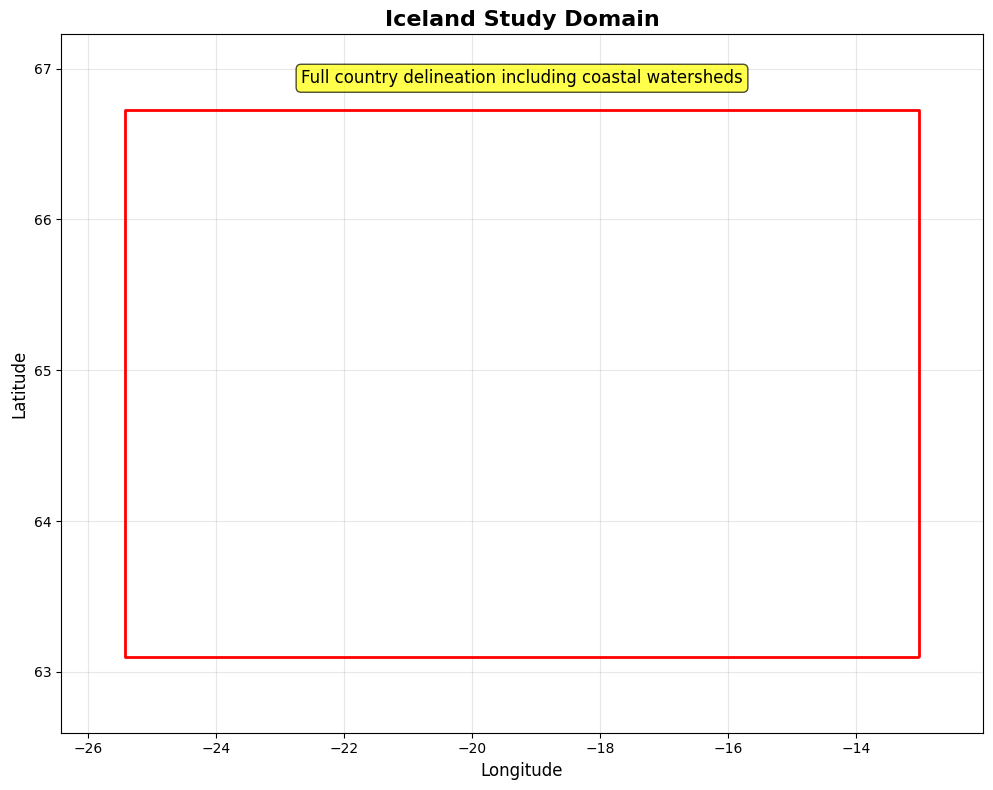

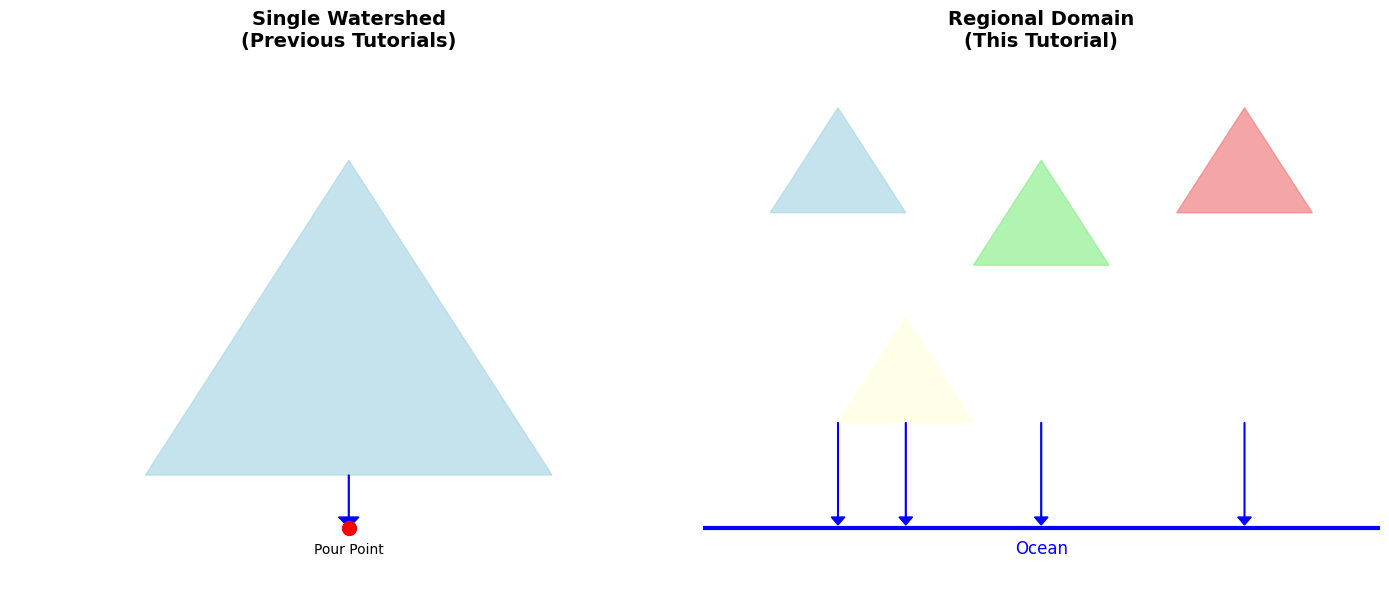

In [4]:
# Create a simple visualization of Iceland's extent
fig, ax = plt.subplots(figsize=(12, 8))

# Create bounding box
iceland_box = box(lon_min, lat_min, lon_max, lat_max)
iceland_bbox = gpd.GeoDataFrame({'geometry': [iceland_box]}, crs='EPSG:4326')

# Plot bounding box
iceland_bbox.boundary.plot(ax=ax, color='red', linewidth=2, label='Study Area')

# Add some context
ax.set_xlim(lon_min - 1, lon_max + 1)
ax.set_ylim(lat_min - 0.5, lat_max + 0.5)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Iceland Study Domain', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add annotation
ax.text(0.5, 0.95, 'Full country delineation including coastal watersheds',
        ha='center', va='top', transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
        fontsize=12)

plt.tight_layout()
plt.show()

# Create conceptual diagram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Traditional watershed delineation
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
# Draw single watershed
watershed = plt.Polygon([(0.5, 0.8), (0.2, 0.2), (0.8, 0.2)], 
                       fill=True, color='lightblue', alpha=0.7)
ax1.add_patch(watershed)
ax1.plot(0.5, 0.1, 'ro', markersize=10)
ax1.text(0.5, 0.05, 'Pour Point', ha='center', fontsize=10)
ax1.arrow(0.5, 0.2, 0, -0.08, head_width=0.03, head_length=0.02, fc='blue', ec='blue')
ax1.set_title('Single Watershed\n(Previous Tutorials)', fontsize=14, fontweight='bold')
ax1.axis('off')

# Regional delineation with coastal watersheds
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
# Draw multiple watersheds
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
watersheds = [
    plt.Polygon([(0.2, 0.9), (0.1, 0.7), (0.3, 0.7)], color=colors[0], alpha=0.7),
    plt.Polygon([(0.5, 0.8), (0.4, 0.6), (0.6, 0.6)], color=colors[1], alpha=0.7),
    plt.Polygon([(0.8, 0.9), (0.7, 0.7), (0.9, 0.7)], color=colors[2], alpha=0.7),
    plt.Polygon([(0.3, 0.5), (0.2, 0.3), (0.4, 0.3)], color=colors[3], alpha=0.7)
]
for ws in watersheds:
    ax2.add_patch(ws)

# Draw coastline
ax2.plot([0, 1], [0.1, 0.1], 'b-', linewidth=3, label='Ocean')
ax2.text(0.5, 0.05, 'Ocean', ha='center', fontsize=12, color='blue')

# Add arrows to ocean
for x in [0.2, 0.5, 0.8, 0.3]:
    ax2.arrow(x, 0.3, 0, -0.18, head_width=0.02, head_length=0.015, fc='blue', ec='blue')

ax2.set_title('Regional Domain\n(This Tutorial)', fontsize=14, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()

## 4. Initialize CONFLUENCE

In [5]:
# Initialize CONFLUENCE
confluence = CONFLUENCE(iceland_config_path)

print("=== CONFLUENCE Initialized ===")
print(f"Project Directory: {confluence.project_dir}")
print(f"Data Directory: {confluence.data_dir}")

2025-05-10 17:45:07,019 - confluence_general - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


=== CONFLUENCE Initialized ===
Project Directory: /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland
Data Directory: /work/comphyd_lab/data/CONFLUENCE_data


## 5. Run Initial Setup Steps

In [6]:
# Setup project structure
print("Step 1: Setting up project...")
confluence.setup_project()
print("✓ Complete\n")

# Note: Pour point creation is skipped since we're doing regional delineation
print("Step 2: Pour point creation skipped (regional delineation)\n")

# Acquire attributes
print("Step 3: Acquiring attributes for Iceland...")
confluence.acquire_attributes()
print("✓ Complete")

2025-05-10 17:45:08,840 - confluence_general - INFO - Setting up project for domain: Iceland


Step 1: Setting up project...


2025-05-10 17:45:09,059 - confluence_general - INFO - Project directory created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland
2025-05-10 17:45:09,060 - confluence_general - INFO - shapefiles directories created


✓ Complete

Step 2: Pour point creation skipped (regional delineation)

Step 3: Acquiring attributes for Iceland...
(2025-05-10 23:45:12) merit_hydro.sh: processing MERIT-Hydro GeoTIFF(s)...
(2025-05-10 23:45:12) merit_hydro.sh: creating cache directory under /work/comphyd_lab/users/darri/cache_Iceland
(2025-05-10 23:45:13) merit_hydro.sh: creating output directory under /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/attributes/elevation/dem
(2025-05-10 23:45:13) merit_hydro.sh: untarring MERIT-Hydro variables under /work/comphyd_lab/users/darri/cache_Iceland
(2025-05-10 23:45:25) merit_hydro.sh: subsetting GeoTIFFs under /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/attributes/elevation/dem


mkdir: cannot create directory ‘/home/darri.eythorsson/empty_dir’: File exists
2025-05-10 17:45:31,489 - confluence_general - INFO - gistool completed successfully.
2025-05-10 17:45:31,490 - confluence_general - INFO - Geospatial data acquisition process completed


(2025-05-10 23:45:31) merit_hydro.sh: deleting temporary files from /work/comphyd_lab/users/darri/cache_Iceland
(2025-05-10 23:45:31) merit_hydro.sh: temporary files from /work/comphyd_lab/users/darri/cache_Iceland are removed
(2025-05-10 23:45:31) merit_hydro.sh: results are produced under /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/attributes/elevation/dem
(2025-05-10 23:45:35) modis.sh: processing MODIS HDF(s)...
(2025-05-10 23:45:35) modis.sh: creating cache directory under /work/comphyd_lab/users/darri/cache_Iceland
(2025-05-10 23:45:35) modis.sh: creating output directory under /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/attributes/landclass
(2025-05-10 23:45:36) modis.sh: building virtual format (.vrt) of MODIS HDFs under /work/comphyd_lab/users/darri/cache_Iceland


ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PRO

(2025-05-10 23:46:47) modis.sh: subsetting HDFs in GeoTIFF format under /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/attributes/landclass


mkdir: cannot create directory ‘/home/darri.eythorsson/empty_dir’: File exists
2025-05-10 17:47:02,073 - confluence_general - INFO - gistool completed successfully.
2025-05-10 17:47:02,075 - confluence_general - INFO - Geospatial data acquisition process completed


(2025-05-10 23:47:01) modis.sh: deleting temporary files from /work/comphyd_lab/users/darri/cache_Iceland
(2025-05-10 23:47:02) modis.sh: temporary files from /work/comphyd_lab/users/darri/cache_Iceland are removed
(2025-05-10 23:47:02) modis.sh: results are produced under /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/attributes/landclass
Mode calculation complete. Result saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/attributes/landclass/domain_Iceland_land_classes.tif
(2025-05-11 00:08:24) soil_class.sh: processing Wouter's wonderful soil_class GeoTIFF(s)...
(2025-05-11 00:08:24) soil_class.sh: creating output directory under /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/attributes/soilclass
(2025-05-11 00:08:24) soil_class.sh: subsetting GeoTIFFs under /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/attributes/soilclass


mkdir: cannot create directory ‘/home/darri.eythorsson/empty_dir’: File exists
2025-05-10 18:08:25,461 - confluence_general - INFO - gistool completed successfully.
2025-05-10 18:08:25,463 - confluence_general - INFO - Geospatial data acquisition process completed


(2025-05-11 00:08:25) soil_class.sh: deleting temporary files from /work/comphyd_lab/users/darri/cache_Iceland
(2025-05-11 00:08:25) soil_class.sh: temporary files from /work/comphyd_lab/users/darri/cache_Iceland are removed
(2025-05-11 00:08:25) soil_class.sh: results are produced under /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/attributes/soilclass
✓ Complete


## 6. Regional Domain Delineation

This is the key step where we delineate the entire region including coastal watersheds.

In [7]:
# Delineate regional domain
print("Step 4: Delineating regional domain...")
print(f"Method: {confluence.config['DOMAIN_DEFINITION_METHOD']}")
print(f"Delineate by pour point: {confluence.config['DELINEATE_BY_POURPOINT']} (Full region!)")
print(f"Include coastal watersheds: {confluence.config['DELINEATE_COASTAL_WATERSHEDS']}")
print(f"Stream threshold: {confluence.config['STREAM_THRESHOLD']}")
print("\nThis will create multiple independent drainage basins...")

confluence.define_domain()

# Check results
basin_path = confluence.project_dir / 'shapefiles' / 'river_basins'
network_path = confluence.project_dir / 'shapefiles' / 'river_network'

basin_count = 0
if basin_path.exists():
    basin_files = list(basin_path.glob('*.shp'))
    if basin_files:
        basins = gpd.read_file(basin_files[0])
        basin_count = len(basins)
        print(f"\n✓ Created {basin_count} watersheds")
        print(f"Total area: {basins.geometry.area.sum() / 1e6:.0f} km²")

network_count = 0
if network_path.exists():
    network_files = list(network_path.glob('*.shp'))
    if network_files:
        rivers = gpd.read_file(network_files[0])
        network_count = len(rivers)
        print(f"✓ Created river network with {network_count} segments")

2025-05-10 18:08:25,479 - confluence_general - INFO - Starting geofabric delineation
2025-05-10 18:08:25,481 - confluence_general - INFO - Geofabric delineation completed successfully
2025-05-10 18:08:25,529 - confluence_general - INFO - Starting geofabric delineation for Iceland
2025-05-10 18:08:25,538 - confluence_general - INFO - Created interim directory: /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/taudem-interim-files/d8
2025-05-10 18:08:25,608 - confluence_general - INFO - Running command: mpirun -n 20 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/pitremove -z /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/attributes/elevation/dem/domain_Iceland_elv.tif -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/taudem-interim-files/d8/elv-fel.tif -v


Step 4: Delineating regional domain...
Method: delineate
Delineate by pour point: False (Full region!)
Include coastal watersheds: True
Stream threshold: 5000

This will create multiple independent drainage basins...


2025-05-10 18:08:25,803 - confluence_general - ERROR - Error executing command: mpirun -n 20 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/pitremove -z /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/attributes/elevation/dem/domain_Iceland_elv.tif -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/taudem-interim-files/d8/elv-fel.tif -v
2025-05-10 18:08:25,804 - confluence_general - ERROR - Error details: --------------------------------------------------------------------------
There are not enough slots available in the system to satisfy the 20
slots that were requested by the application:

  /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/pitremove

Either request fewer slots for your application, or make more slots
available for use.

A "slot" is the Open MPI term for an allocatable unit where we can
launch a process.  The number of slots available are defined by the
environment in which Open MPI processes are run:

  1. Hostfile, via "slots=N" 


✓ Created 3277 watersheds
Total area: 0 km²
✓ Created river network with 2683 segments


## 7. Visualize Regional Domain

2025-05-10 18:37:46,120 - confluence_general - INFO - Creating domain visualization...


Creating regional domain visualization...


2025-05-10 18:37:51,057 - confluence_general - INFO - Domain map saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/plots/domain/domain_map.png
2025-05-10 18:37:51,061 - confluence_general - INFO - Domain visualization created: /work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/plots/domain/domain_map.png


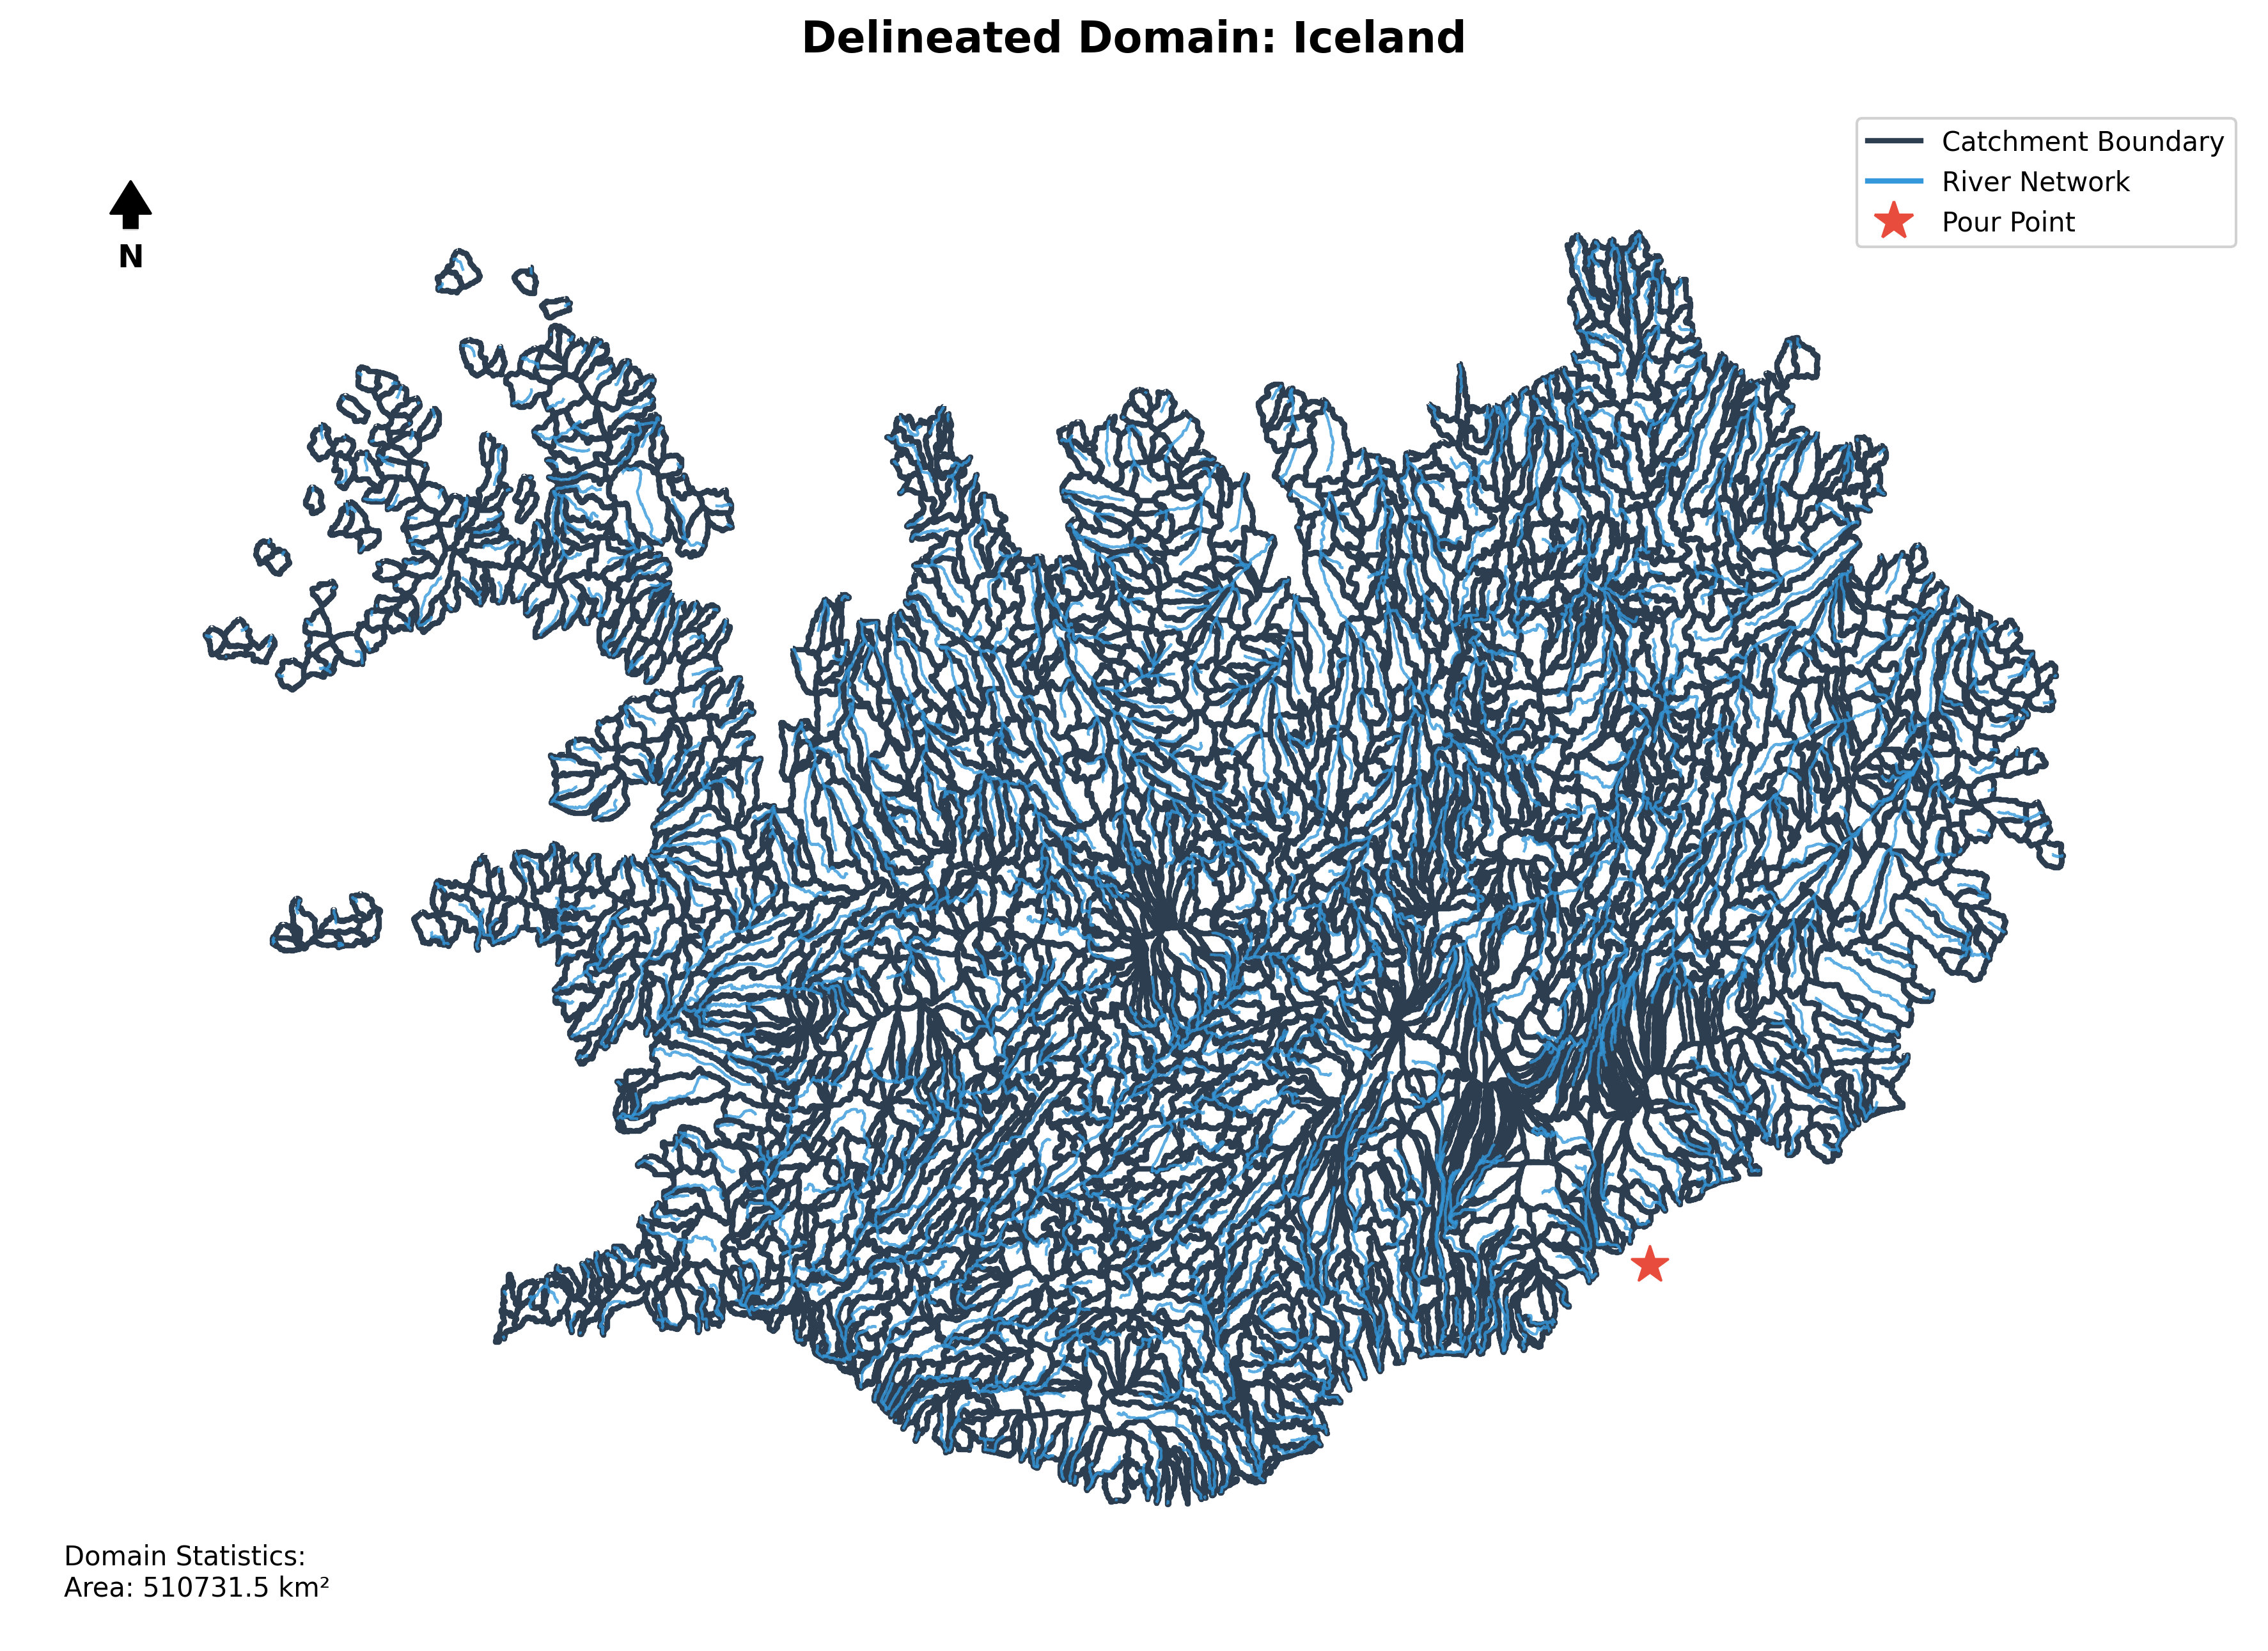

In [8]:
# Create domain visualization
print("Creating regional domain visualization...")
confluence.plot_domain()

# Display the plot if it exists
plot_path = confluence.project_dir / 'plots' / 'domain' / 'domain_map.png'
if plot_path.exists():
    from IPython.display import Image, display
    display(Image(filename=str(plot_path)))
else:
    # Create custom visualization
    if basin_path.exists() and basin_files:
        fig, ax = plt.subplots(figsize=(14, 10))
        
        # Plot watersheds
        basins.plot(ax=ax, column='GRU_ID', cmap='tab20', 
                   edgecolor='black', linewidth=0.5, legend=False)
        
        # Plot river network if available
        if network_path.exists() and network_files:
            rivers.plot(ax=ax, color='blue', linewidth=1)
        
        ax.set_title(f'Iceland Regional Domain - {basin_count} Watersheds', 
                    fontsize=16, fontweight='bold')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        # Add annotation about coastal watersheds
        ax.text(0.02, 0.98, f'Including coastal watersheds\nTotal watersheds: {basin_count}',
                transform=ax.transAxes, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=12)
        
        plt.tight_layout()
        plt.show()

## 8. Apply GRU-Based Discretization

In [9]:
# Apply discretization
print("Step 5: Creating HRUs...")
print(f"Method: {confluence.config['DOMAIN_DISCRETIZATION']}")

confluence.discretize_domain()

# Check results
hru_path = confluence.project_dir / 'shapefiles' / 'catchment'
if hru_path.exists():
    hru_files = list(hru_path.glob('*.shp'))
    if hru_files:
        hru_gdf = gpd.read_file(hru_files[0])
        
        print(f"\n✓ Created {len(hru_gdf)} HRUs")
        print(f"Number of GRUs: {hru_gdf['GRU_ID'].nunique()}")
        
        # Show some statistics
        hru_stats = hru_gdf.groupby('GRU_ID').size()
        print(f"\nHRU distribution:")
        print(f"  Min HRUs per GRU: {hru_stats.min()}")
        print(f"  Max HRUs per GRU: {hru_stats.max()}")
        print(f"  Avg HRUs per GRU: {hru_stats.mean():.1f}")

2025-05-10 18:37:55,150 - confluence_general - INFO - Discretizing domain using method: GRUs
2025-05-10 18:37:55,151 - confluence_general - INFO - Starting domain discretization using method: grus
2025-05-10 18:37:55,153 - confluence_general - INFO - Step 1/2: Running discretization method
2025-05-10 18:37:55,154 - confluence_general - INFO - config domain name Iceland


Step 5: Creating HRUs...
Method: GRUs


2025-05-10 18:37:55,548 - confluence_general - INFO - Calculating mean elevation for each HRU
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
/home/darri.eythorsson/code/CONFLUENCE/utils/geospatial_utils/discretization_utils.py:207: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_utm = gru_gdf.geometry.centroid
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 105562844.697175741 of field GRU_area of feature 75 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-p


✓ Created 3837 HRUs
Number of GRUs: 3837

HRU distribution:
  Min HRUs per GRU: 1
  Max HRUs per GRU: 1
  Avg HRUs per GRU: 1.0


## 9. Analyze Regional Characteristics

/tmp/ipykernel_292027/4045124394.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas_km2 = basins.geometry.area / 1e6


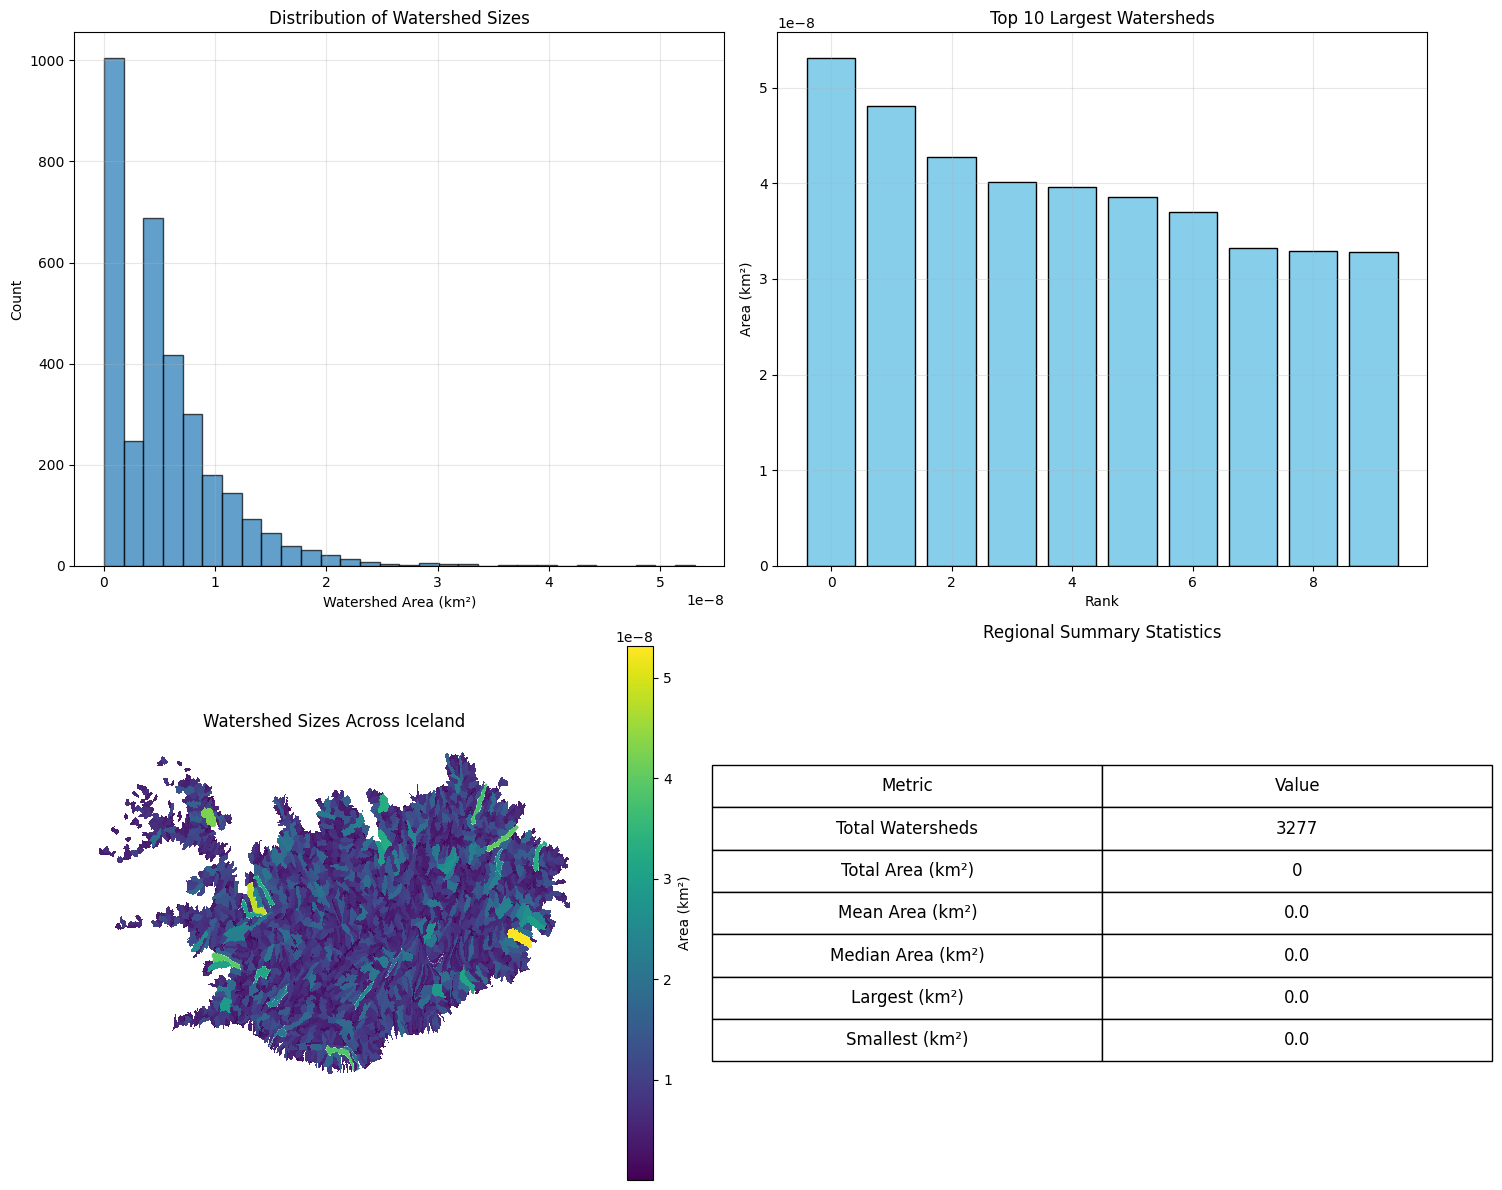

In [10]:
# Analyze watershed characteristics
if 'basins' in locals():
    # Create summary statistics
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Watershed areas
    areas_km2 = basins.geometry.area / 1e6
    ax1.hist(areas_km2, bins=30, edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Watershed Area (km²)')
    ax1.set_ylabel('Count')
    ax1.set_title('Distribution of Watershed Sizes')
    ax1.grid(True, alpha=0.3)
    
    # Largest watersheds
    top_10 = areas_km2.nlargest(10)
    ax2.bar(range(len(top_10)), top_10, color='skyblue', edgecolor='black')
    ax2.set_xlabel('Rank')
    ax2.set_ylabel('Area (km²)')
    ax2.set_title('Top 10 Largest Watersheds')
    ax2.grid(True, alpha=0.3)
    
    # Geographic distribution
    basins.plot(ax=ax3, column=areas_km2, cmap='viridis', 
               legend=True, legend_kwds={'label': 'Area (km²)'})
    ax3.set_title('Watershed Sizes Across Iceland')
    ax3.axis('off')
    
    # Summary statistics table
    stats_data = {
        'Metric': ['Total Watersheds', 'Total Area (km²)', 'Mean Area (km²)', 
                  'Median Area (km²)', 'Largest (km²)', 'Smallest (km²)'],
        'Value': [len(basins), f"{areas_km2.sum():,.0f}", f"{areas_km2.mean():.1f}",
                 f"{areas_km2.median():.1f}", f"{areas_km2.max():.1f}", f"{areas_km2.min():.1f}"]
    }
    stats_df = pd.DataFrame(stats_data)
    
    ax4.axis('tight')
    ax4.axis('off')
    table = ax4.table(cellText=stats_df.values,
                     colLabels=stats_df.columns,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 2)
    ax4.set_title('Regional Summary Statistics')
    
    plt.tight_layout()
    plt.show()

## 10. Continue Workflow

In [ ]:
# Continue with remaining workflow steps
print("Continuing with remaining workflow steps...\n")

# Process observed data
print("Step 6: Processing observed data...")
confluence.process_observed_data()
print("✓ Complete\n")

# Acquire forcing data
print("Step 7: Acquiring forcing data for Iceland...")
confluence.acquire_forcings()
print("✓ Complete\n")

# Model-agnostic preprocessing
print("Step 8: Model-agnostic preprocessing...")
confluence.model_agnostic_pre_processing()
print("✓ Complete\n")

# Model-specific preprocessing
print("Step 9: Preparing model input files...")
confluence.model_specific_pre_processing()
print("✓ Complete")

2025-05-10 18:38:31,461 - confluence_general - INFO - Processing observed data
2025-05-10 18:38:31,463 - confluence_general - INFO - Processing WSC streamflow data
2025-05-10 18:38:31,476 - confluence_general - ERROR - Issue in streamflow data preprocessing: [Errno 2] No such file or directory: '/work/comphyd_lab/data/CONFLUENCE_data/domain_Iceland/observations/streamflow/raw_data/Discharge.Working@09AH001.20110101_corrected.csv'
2025-05-10 18:38:31,477 - confluence_general - INFO - Observed data processing completed successfully


Continuing with remaining workflow steps...

Step 6: Processing observed data...
✓ Complete

Step 7: Acquiring forcing data for Iceland...


2025-05-10 18:38:35,032 - confluence_general - INFO - datatool job submitted successfully.


## 11. Summary and Key Concepts

### What Makes Regional Modeling Different?

1. **Multiple Independent Systems**: Instead of one watershed, we model many
2. **Coastal Watersheds**: Include basins draining directly to ocean
3. **No Single Pour Point**: Use bounding box to define region
4. **Larger Scale**: National or regional coverage

### Key Configuration Parameters

```yaml
DELINEATE_BY_POURPOINT: False      # Don't focus on single outlet
DELINEATE_COASTAL_WATERSHEDS: True # Include coastal drainage
DOMAIN_DEFINITION_METHOD: delineate # Still use delineation method
STREAM_THRESHOLD: 5000             # Define stream network
```

### Use Cases for Regional Modeling

- **National water resources assessment**
- **Climate change impact studies**
- **Regional flood forecasting**
- **Water balance calculations**
- **Comparative watershed studies**

### Challenges and Considerations

1. **Computational Requirements**: Many watersheds = more computation
2. **Data Management**: Handling multiple independent systems
3. **Calibration Strategy**: How to calibrate multiple watersheds
4. **Routing Complexity**: Independent systems don't connect

In [ ]:
# Final summary
print("=== Iceland Regional Domain Complete ===\n")
print(f"Domain: {confluence.config['DOMAIN_NAME']}")
print(f"Method: Regional delineation with coastal watersheds")

if 'basin_count' in locals():
    print(f"\nResults:")
    print(f"  Total watersheds: {basin_count}")
    print(f"  River segments: {network_count}")
    if 'hru_gdf' in locals():
        print(f"  Total HRUs: {len(hru_gdf)}")

print(f"\nKey outputs:")
print(f"  - Basin shapefiles: {basin_path}")
print(f"  - River network: {network_path}")
print(f"  - HRU shapefiles: {hru_path}")
print(f"\nNext step: Run regional hydrological model")